# Modelo Presa-Predador
- $x(t) \to$ presa;
- $y(t) \to$ predador
$$\begin{cases}\dfrac{dx}{dt} = \alpha x - \beta xy \\ \dfrac{dy}{dt} = \delta xy - \gamma y \end{cases}$$

### Matriz Jacobiana:
#### Matriz de sensibilidade das equações em relação às variáveis

$$J = \begin{bmatrix} \alpha - \beta\ y & -\beta\ x \\ \delta\ y & \delta\ x - \gamma \end{bmatrix}$$


### Pontos de Equilíbrio:
$$\dfrac{d}{dt} \binom{x}{y} = \binom{0}{0} \Longrightarrow \binom{x}{y} \in \left\{ \binom{0}{0}, \binom{\gamma\ /\ \delta}{\alpha\ /\ \beta} \right\} \equiv \left\{ p_1, p_2 \right\}$$

## Objetivo:
### Solucionar numericamente o problema via Runge-Kutta

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def runge_kutta_presa_predador(x1, y1, alfa, beta, delta, gama, ti=0, tf=1, N=100):
    f_x_y_presa    = lambda x, y: alfa * x - beta * x * y
    f_x_y_predador = lambda x, y: delta * x * y - gama * y

    ts = np.linspace(ti, tf, N+1)
    LX, LY = [x1], [y1]
    h = (tf - ti) / N

    for _ in range(N):
        f1_presa = f_x_y_presa(x1, y1)
        f1_predador = f_x_y_predador(x1, y1)

        f2_presa = f_x_y_presa(x1 + h * f1_presa, y1 + h * f1_predador)
        f2_predador = f_x_y_predador(x1 + h * f1_presa, y1 + h * f1_predador)

        x2 = x1 + (h/2) * (f1_presa + f2_presa)
        y2 = y1 + (h/2) * (f1_predador + f2_predador)

        LX.append(x2)
        LY.append(y2)
        x1, y1 = x2, y2

    return np.asarray([LX, LY])

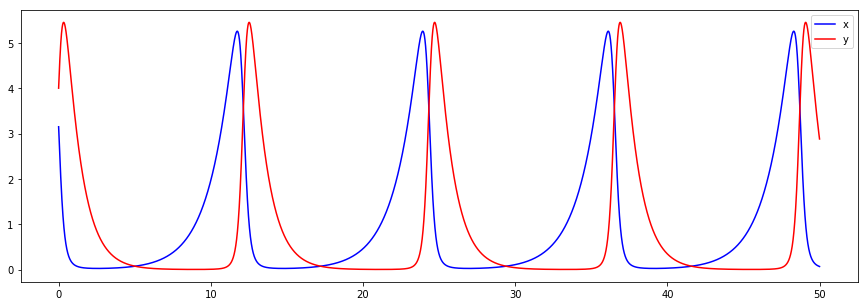

In [3]:
alfa, beta, gama, delta  =  2/3, 2.5/3, 1, 1    # alfa,beta,gama,delta = 1,1,1,1
x,  y  =  gama/delta + 2.15,  alfa/beta + 3.20  # x, y = 0, 0

N, ti, tf = 30000, 0.0, 50.0
h = (tf - ti) / N
ts = np.linspace(ti, tf, N+1)
res_x, res_y = runge_kutta_presa_predador(x, y, alfa, beta, delta, gama, ti, tf, N)

plt.figure(figsize=(15,5))
plt.plot(ts, res_x, 'b', label="x")
plt.plot(ts, res_y, 'r', label="y")
plt.legend(loc=0) ; plt.show()

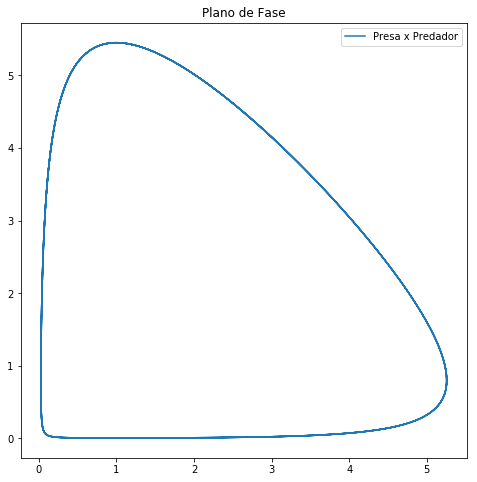

In [4]:
plt.figure(figsize=(8,8))
plt.title("Plano de Fase")
plt.plot(res_x, res_y, label="Presa x Predador")
plt.legend(loc=0)
plt.show()

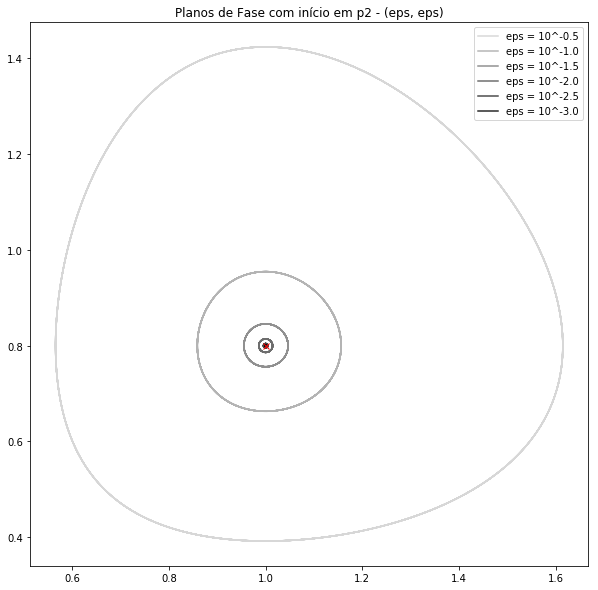

In [5]:
wat = lambda x: -0.276 * x + 0.02

plt.figure(figsize=(10,10))
plt.title("Planos de Fase com início em p2 - (eps, eps)")
for eps in (.316, .100, .0316, .0100, .00316, .00100):
    x = gama / delta - eps
    y = alfa /  beta - eps
    cc = np.log10(eps)
    res_x, res_y = runge_kutta_presa_predador(x, y, alfa, beta, delta, gama, ti, tf, N)
    plt.plot(res_x, res_y, color=(0,0,0,wat(cc)), label="eps = 10^{:.1f}".format(cc))
plt.plot([gama / delta], [alfa /  beta], "rx")
plt.legend(loc=0)
plt.show()

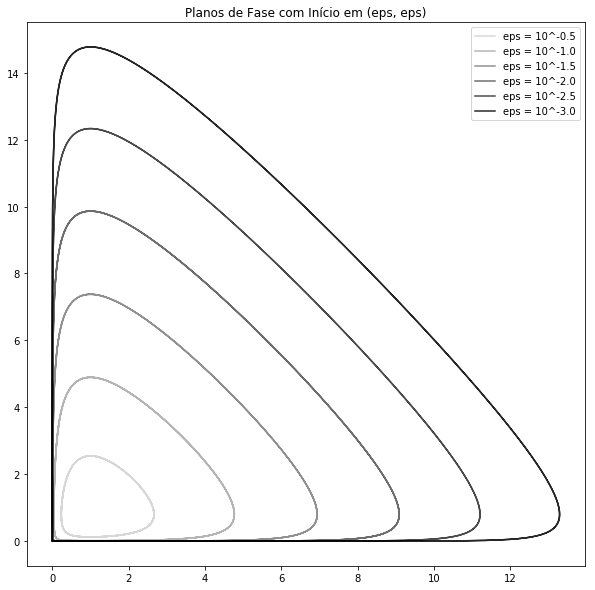

In [6]:
wat = lambda x: -0.276 * x + 0.02

plt.figure(figsize=(10,10))
plt.title("Planos de Fase com Início em (eps, eps)")
for eps in (.316, .100, .0316, .0100, .00316, .00100):
    x, y = eps, eps  # x, y = gama/delta - eps, alfa/beta - eps
    cc = np.log10(eps)
    res_x, res_y = runge_kutta_presa_predador(x, y, alfa, beta, delta, gama, ti, tf, N)
    plt.plot(res_x, res_y, color=(0,0,0,wat(cc)), label="eps = 10^{:.1f}".format(cc))
plt.legend(loc=0) ; plt.show()

# Convergência da solução ao refinar os intervalos de tempo:

In [7]:
def presa_predador_com_refinamento(x1,y1,alfa,beta,delta,gama,ti=0,tf=1,N0=100,depth=5):
    ns = [N0]
    for _ in range(depth):
        ns.append(ns[-1] * 2)
    results = []
    for n in ns:
        results.append(runge_kutta_presa_predador(x1,y1,alfa,beta,delta,gama,ti,tf,n))
    for k in range(depth+1):
        salto = 2**k
        # Selecionamos todas as linhas e pulamos várias colunas (andando de 2**k em 2**k):
        results[k] = results[k][::, ::salto]
    return results

In [8]:
N0, depth, ti, tf = 20, 10, 0., 10.
ts = np.linspace(ti, tf, N0+1)
resultados = presa_predador_com_refinamento(x, y, alfa,beta,delta,gama, ti,tf,N0,depth)

# Escolha de função de distância:
distancia = lambda u, v: max(abs(u-v)) #(norma sup) #Outras normas: sum(abs(u-v)) ; np.linalg.norm(u-v)

x_dist, y_dist = [], []  #=> arrays das distâncias entre soluções vizinhas

# percorrendo soluções vizinhas (r1, r2) no array dos resultados:
res1, res2 = resultados[:-1], resultados[1:]
for (x1, y1), (x2, y2) in zip(res1, res2):
    x_dist.append(distancia(x1, x2))
    y_dist.append(distancia(y1, y2))
x_dist, y_dist = np.array(x_dist), np.array(y_dist)

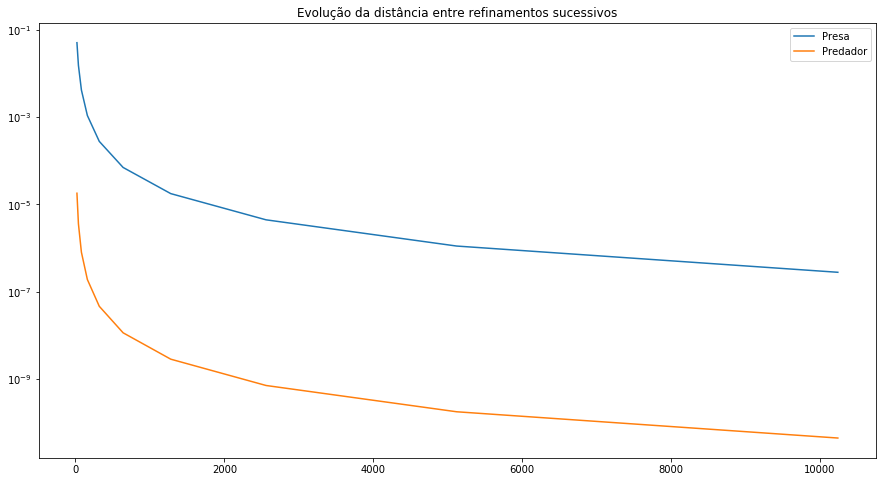

In [9]:
plt.figure(figsize=(15,8))
plt.title("Evolução da distância entre refinamentos sucessivos")
npts = N0 * 2**np.arange(len(x_dist))
plt.semilogy(npts, x_dist, label="Presa")
plt.semilogy(npts, y_dist, label="Predador")
plt.legend(loc=0)
plt.show()

## $$\ddot \smile$$